# Part 0: Sample Selection

This is the first notebook for reproducing [Imig et al 2025](https://astrojimig.github.io/pdfs/Imig_MW_density.pdf). In this notebook, all of the figures and numbers presented as results in the paper are produced. 

This notebook contains Figures 1-3 from the paper


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import astropy.io.fits as fits

# Sample Setup and helper functions
from mw_density import sample_selection, plotting_helpers

import matplotlib as mpl
from matplotlib.colors import LogNorm

from scipy.spatial import ConvexHull
from scipy.interpolate import interpn

# Define Plotting Parameters
params = {
    "axes.labelsize": 36,
    "xtick.labelsize": 36,
    "ytick.labelsize": 36,
    "text.usetex": False,
    "lines.linewidth": 1,
    "axes.titlesize": 22,
    "font.family": "serif",
    "font.size": 36,
}
plt.rcParams.update(params)

figure_directory = "results/figures/"

In [2]:
age_bins, mh_bins = sample_selection.setup_maap_bins()
allstar = fits.open(sample_selection.get_allstar_filepath())[1].data
distmass = fits.open(sample_selection.get_distmass_filepath())[1].data
data_mask = sample_selection.get_data_mask(allstar, distmass)
low_alpha_mask, high_alpha_mask = sample_selection.get_alpha_masks(
    allstar[data_mask]
)

apogee_sample = fits.open("data/apogee_sample.fits")[1].data
logg_min_lim = np.min(apogee_sample["LOGG"])
logg_max_lim = np.max(apogee_sample["LOGG"])

# Figure 1: Sample Overview

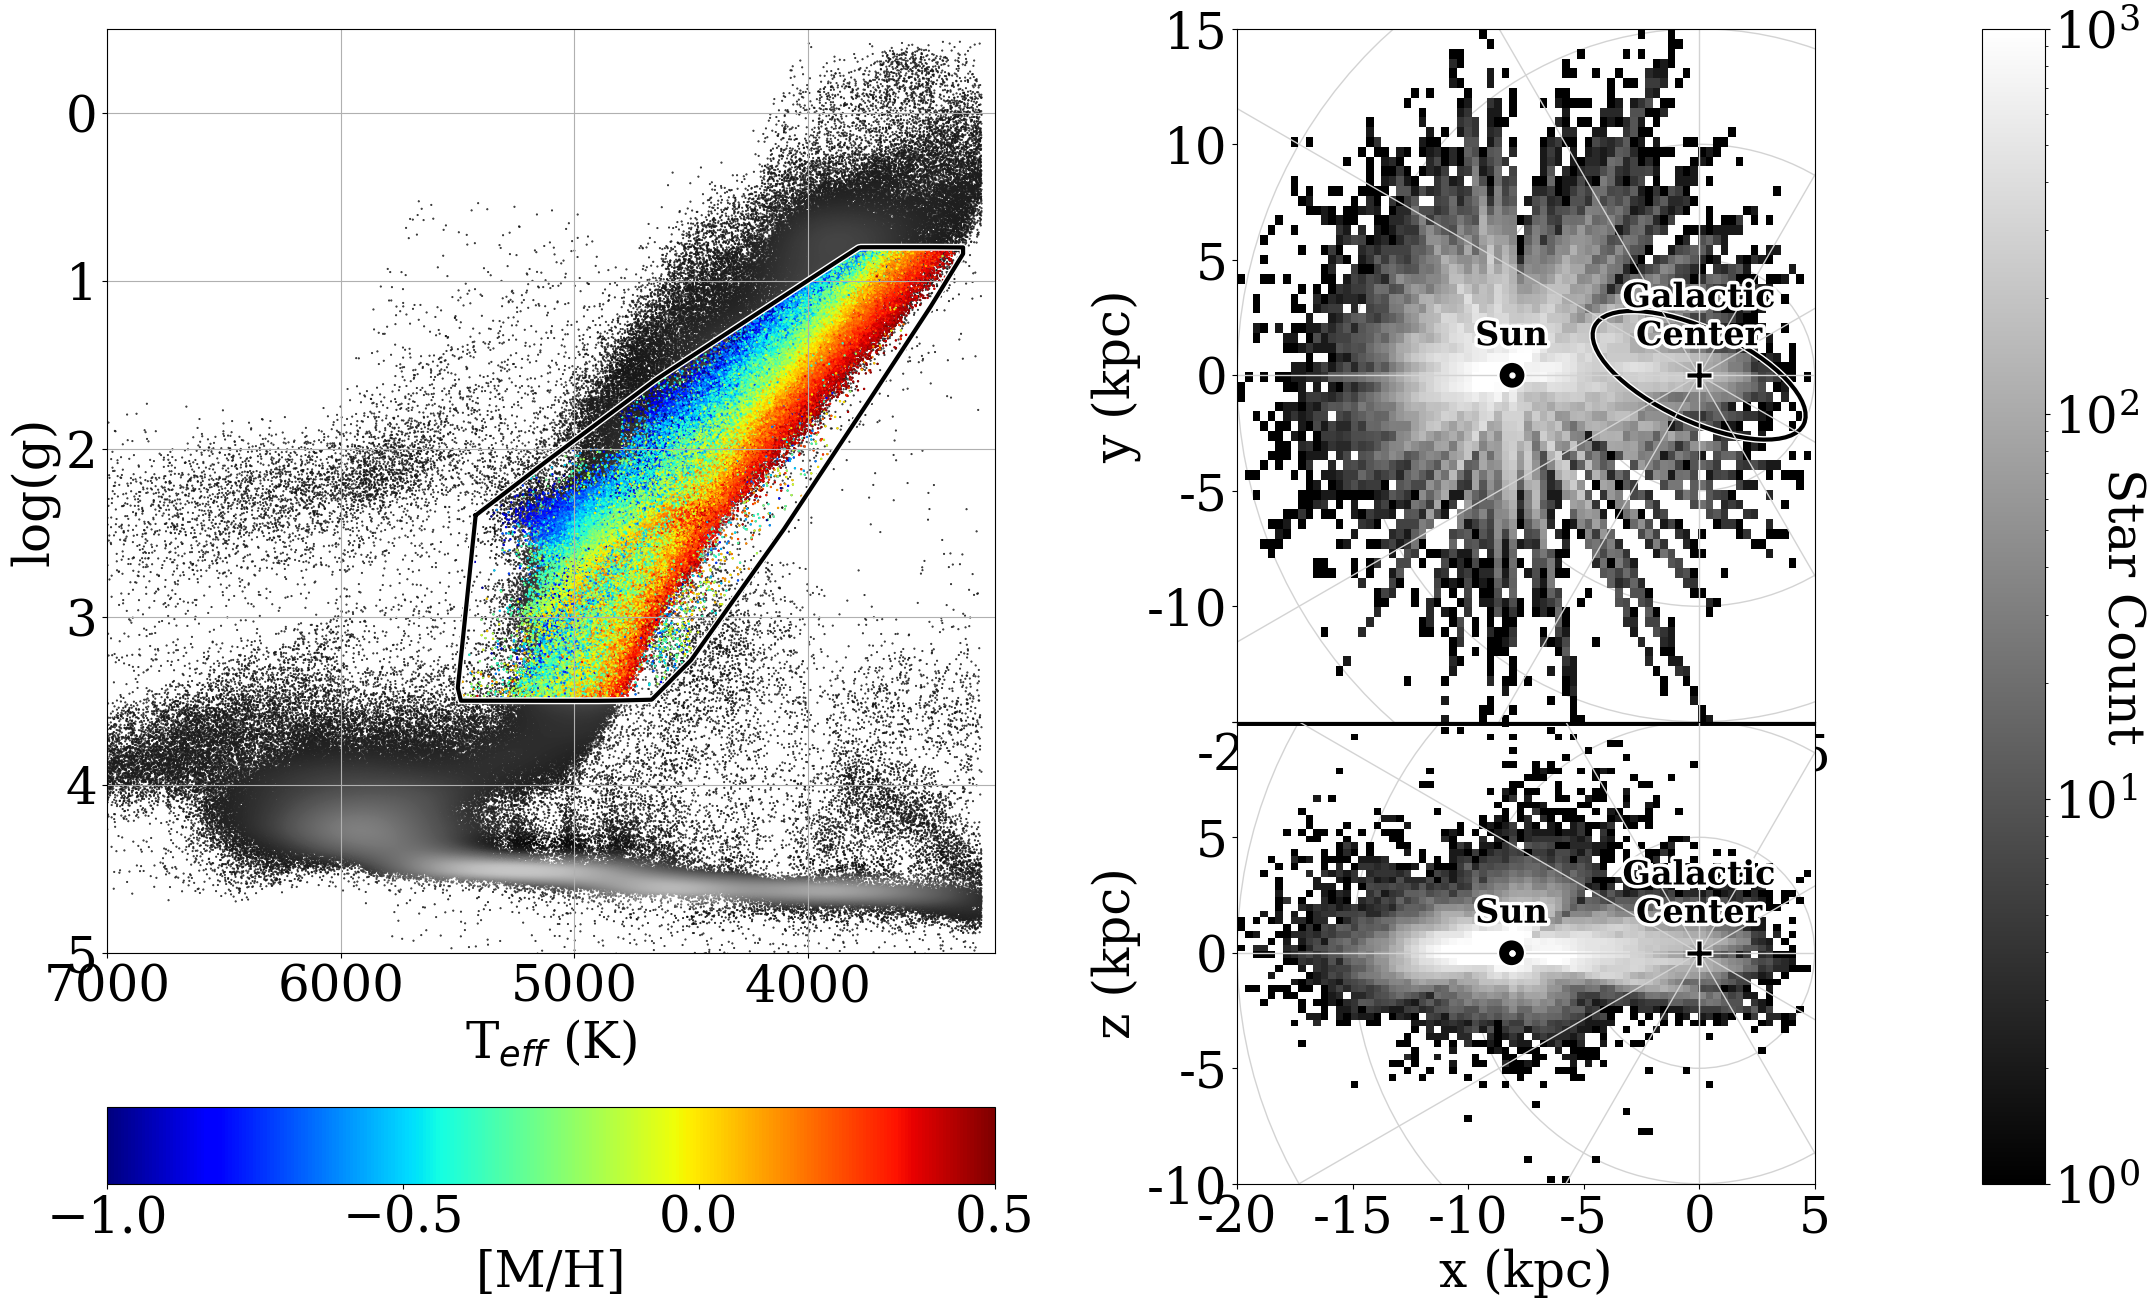

In [3]:
hull = ConvexHull(np.array([apogee_sample["TEFF"], apogee_sample["LOGG"]]).T)
hull_x, hull_y = hull.points[hull.vertices].T

plt.figure(figsize=(25, 15))
ax_ratio = (15, 13)

# HR diagram
ax0 = plt.subplot2grid(
    (15, 26), (0, 0), colspan=ax_ratio[1] - 1, rowspan=ax_ratio[0] - 3
)
# [M/H] colorbar
cax0 = plt.subplot2grid(
    (15, 26), (ax_ratio[0] - 1, 0), colspan=ax_ratio[1] - 1, rowspan=1
)

# face-on counts
ax1 = plt.subplot2grid((15, 26), (0, 13), colspan=ax_ratio[1] - 1, rowspan=9)
plotting_helpers.plot_sun_and_gc(ax=ax1)

# edge-on counts
ax2 = plt.subplot2grid(
    (15, 26), (ax_ratio[0] - 6, 13), colspan=ax_ratio[1] - 1, rowspan=6
)
plotting_helpers.plot_sun_and_gc(ax=ax2, labels="False")

# Star count colorbar
ax_c = plt.subplot2grid((15, 26), (0, 25), colspan=1, rowspan=ax_ratio[0])


for r in [5, 10, 15, 20]:
    circgrid = plt.Circle((0, 0), r, facecolor="None", edgecolor="lightgray")
    ax1.add_patch(circgrid)
    circgrid = plt.Circle((0, 0), r, facecolor="None", edgecolor="lightgray")
    ax2.add_patch(circgrid)

im = ax1.hist2d(
    apogee_sample["GALACTIC_X"],
    apogee_sample["GALACTIC_Y"],
    cmap="gray",
    bins=100,
    norm=LogNorm(1, 1e3),
)
cbar = plt.colorbar(im[3], cax=ax_c, label="N stars")
cbar.set_label(label="Star Count", rotation=-90)

ax2.hist2d(
    apogee_sample["GALACTIC_X"],
    apogee_sample["GALACTIC_Z"],
    cmap="gray",
    bins=100,
    norm=LogNorm(1, 1e3),
)

ax1.set_ylabel("y (kpc)")
ax2.set_ylabel("z (kpc)")
ax2.set_xlabel("x (kpc)")

ax1.set_ylim(-15, 15)
ax2.set_ylim(-5, 5)
ax2.axhline(10, c="k", lw=5)
ax2.set_yticks([-10, -5, 0, 5, 10])
ax2.set_yticklabels(["-10", "-5", 0, 5, ""])
ax1.set_yticks([-15, -10, -5, 0, 5, 10, 15])
ax1.set_yticklabels(["", "-10", "-5", "0", 5, 10, 15])
ax1.set_xticklabels("")

for ax in [ax1, ax2]:
    ax.set_xlim(-20, 5)
    xticks = [-20, -15, -10, -5, 0, 5]
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(x) for x in xticks])
    # ax.grid()
    ax.set_aspect("equal")
    for m in np.arange(0, 180, 30):
        linx = np.linspace(-20, 20, 100)
        ax.plot(linx, np.tan(np.deg2rad(m)) * linx, c="lightgray")


Gbar = mpl.patches.Ellipse(
    [0, 0], 10.0, 0.4 * 10.0, angle=-25, facecolor="None", edgecolor="w", lw=5
)
ax1.add_patch(Gbar)
Gbar = mpl.patches.Ellipse(
    [0, 0], 10.0, 0.4 * 10.0, angle=-25, facecolor="None", edgecolor="k", lw=3
)
ax1.add_patch(Gbar)
# ax1.set_title('Spatial Distribution')

# HR Diagram
# plt.scatter(allstar['TEFF'], allstar['LOGG'], s=1,marker='.',c='gray')

ax0.set_xlim(7000, 3200)
ax0.set_ylim(5, -0.5)

alph_x = allstar["TEFF"][allstar["TEFF"] > 3000]
alph_y = allstar["LOGG"][allstar["TEFF"] > 3000]
data, x_e, y_e = np.histogram2d(alph_x, alph_y, bins=50, density=True)
alph_z = interpn(
    (0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])),
    data,
    np.vstack([alph_x, alph_y]).T,
    method="splinef2d",
    bounds_error=False,
)
idx = alph_z.argsort()
alph_x, alph_y, alph_z = alph_x[idx], alph_y[idx], alph_z[idx]
ax0.scatter(alph_x, alph_y, c=alph_z, s=1, marker=".", cmap="Greys_r")
im = ax0.scatter(
    apogee_sample["TEFF"],
    allstar["LOGG"][data_mask],
    s=2,
    marker=".",
    c=apogee_sample["M_H"],
    cmap="jet",
    vmin=-1.0,
    vmax=0.5,
)

plt.colorbar(im, cax=cax0, orientation="horizontal", label="[M/H]")

tmax = np.max(apogee_sample["TEFF"])
tmin = np.min(apogee_sample["TEFF"])
lmin = np.min(apogee_sample["LOGG"])
lmax = np.max(apogee_sample["LOGG"])
# ax0.plot([tmin,tmin,tmax,tmax,tmin],[lmax,lmin,lmin,lmax,lmax],c='k',lw=3)
ax0.plot(
    np.append(hull_x, hull_x[0]), np.append(hull_y, hull_y[0]), c="w", lw=5
)
ax0.plot(
    np.append(hull_x, hull_x[0]), np.append(hull_y, hull_y[0]), c="k", lw=3
)

ax1.scatter(
    [-8.1],
    [0],
    marker="o",
    c="k",
    facecolor="k",
    s=250,
    zorder=12,
    label="Sun",
    lw=2,
    path_effects=[patheffects.withStroke(linewidth=5, foreground="w")],
)

ax.scatter(
    [-8.1],
    [0],
    marker=".",
    c="w",
    s=50,
    zorder=12,
)

ax0.grid()
ax0.set_ylabel("log(g)")
ax0.set_xlabel(r"T$_{eff}$ (K)")
# ax0.set_title('Kiel Diagram')

# plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(figure_directory + "data_sample.png", bbox_inches="tight")

plt.show()


Number of Stars in Sample: 203197


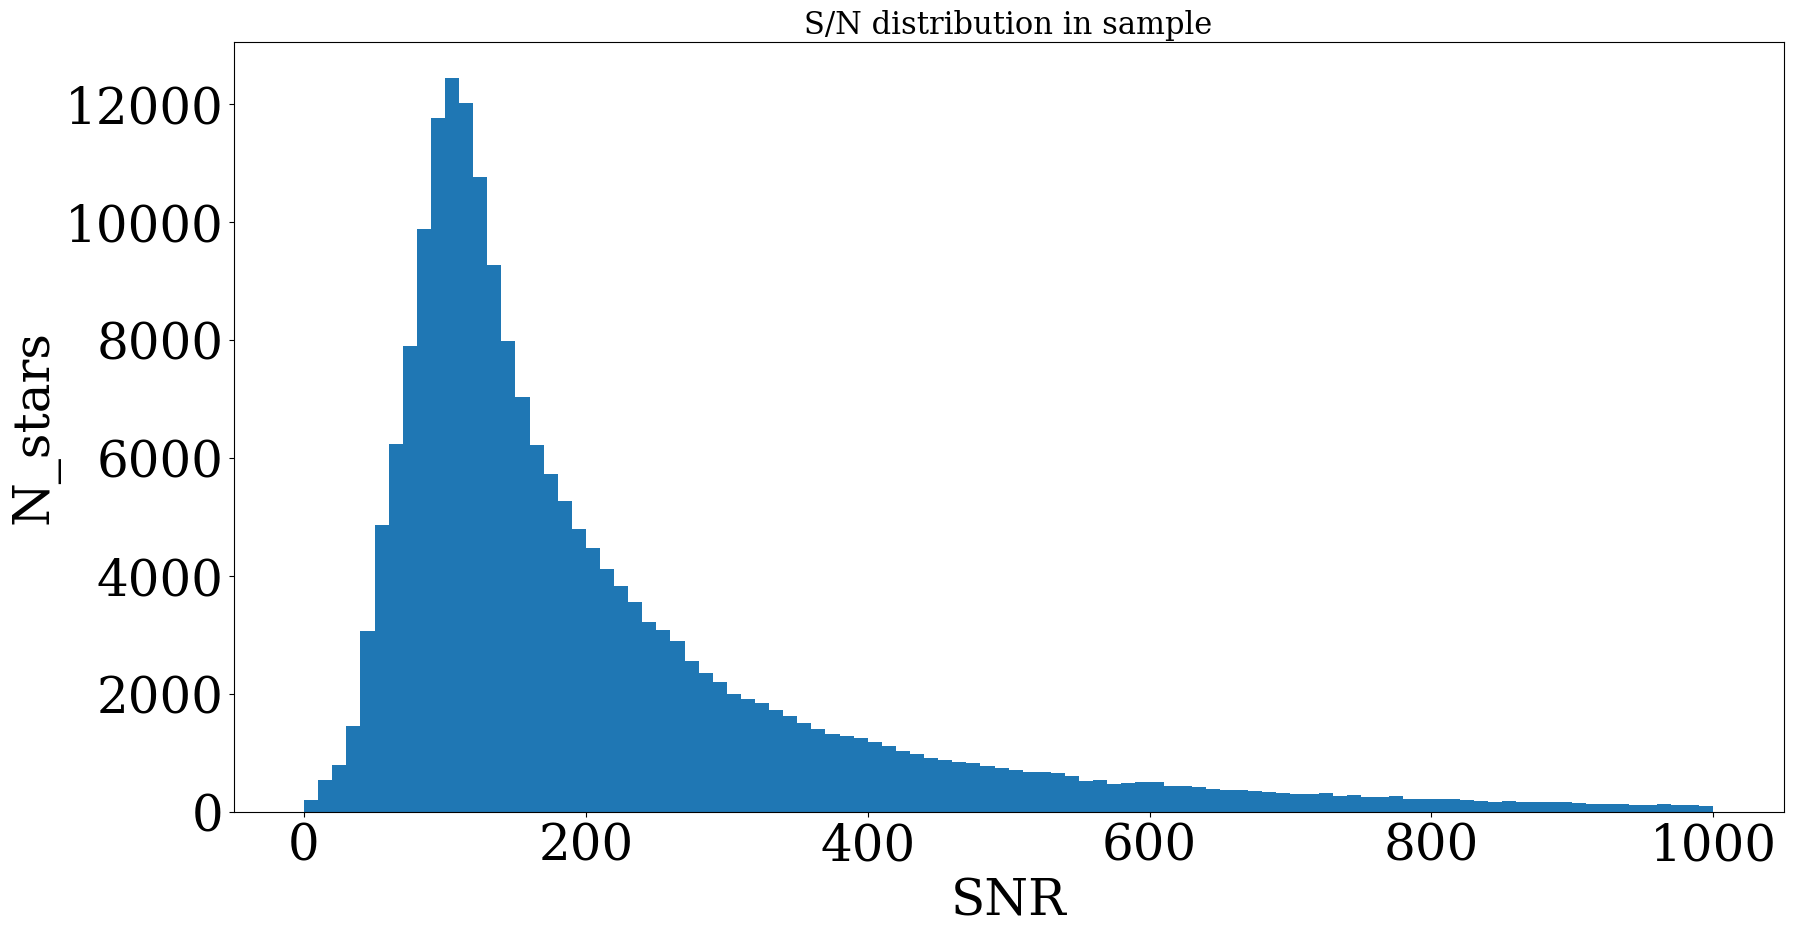

Min: 4.858326435089111
Median: 153.44985961914062
Max: 2829.608154296875
6049 stars (3%) stars with S/N < 50


In [4]:
# Signal to Noise Distribution
N_stars = len(apogee_sample)
print(f"Number of Stars in Sample: {N_stars}")

plt.figure(figsize=(20, 10))
plt.hist(allstar["SNR"][data_mask], range=(0, 1000), bins=100)
plt.xlabel("SNR")
plt.ylabel("N_stars")
plt.title("S/N distribution in sample")
plt.show()

print(f"Min: {np.min(allstar['SNR'][data_mask])}")
print(f"Median: {np.median(allstar['SNR'][data_mask])}")
print(f"Max: {np.max(allstar['SNR'][data_mask])}")

x = len(allstar["SNR"][data_mask][allstar["SNR"][data_mask] < 50])
print(f"{x} stars ({round(100 * x / N_stars)}%) stars with S/N < 50")

# Figure 2: [M/H]-[$\alpha$/M] split

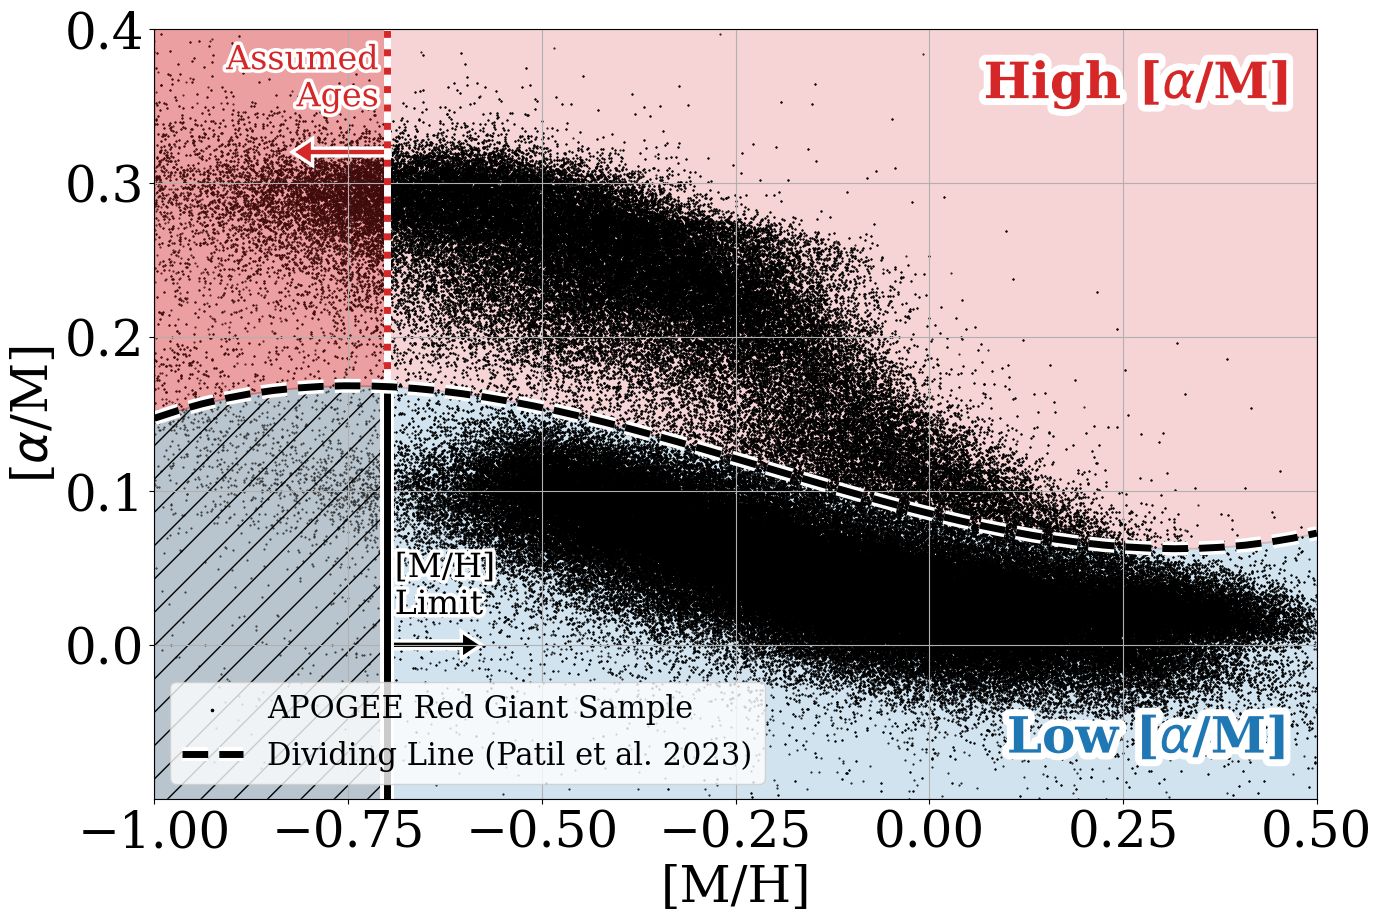

<Figure size 640x480 with 0 Axes>

In [5]:
plt.figure(figsize=(15, 10))

f = np.linspace(-1, 0.5)
halphaline = np.array([sample_selection.alpha_line_patil2023(i) for i in f])

plt.fill_between(
    f, np.ones(len(f)) * -0.1, halphaline, color="tab:blue", alpha=0.2
)
plt.fill_between(
    f, halphaline, np.ones(len(f)) * 4, color="tab:red", alpha=0.2
)
# plt.fill_between(f, halphaline-0.025,halphaline+0.025,color='k',alpha=0.3)

tmp_m = (allstar["LOGG"] <= logg_max_lim) & (allstar["LOGG"] >= logg_min_lim)
tmp_m = tmp_m & (allstar["EXTRATARG"] == 0)
tmp_m = tmp_m & (allstar["ALPHA_M"] >= -1.0) & (allstar["TEFF"] <= 5500)
tmp_m = tmp_m & ((allstar["ASPCAPFLAG"] & (2**23)) == 0)  # STAR_BAD

plt.scatter(
    allstar["M_H"][tmp_m], allstar["ALPHA_M"][tmp_m], s=1, marker=".", c="k"
)

plt.scatter(
    allstar["M_H"][data_mask],
    allstar["ALPHA_M"][data_mask],
    s=1,
    marker=".",
    c="k",
)
plt.scatter(
    [-10], [0], s=10, marker=".", c="k", label="APOGEE Red Giant Sample"
)
plt.xlim(-1.0, 0.5)
plt.ylim(-0.1, 0.4)

# plt.colorbar()
plt.grid()
plt.xlabel("[M/H]", fontsize=36)
plt.ylabel(r"[$\alpha$/M]", fontsize=36)
plt.text(
    0.07,
    0.355,
    r"High [$\alpha$/M]",
    weight="bold",
    color="tab:red",
    fontsize=36,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")],
)
plt.text(
    0.1,
    -0.07,
    r"Low [$\alpha$/M]",
    weight="bold",
    color="tab:blue",
    fontsize=36,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")],
)

# metallicity limit
min_feh = np.min(allstar["M_H"][data_mask][low_alpha_mask])
plt.plot(
    [min_feh, min_feh],
    [-0.1, sample_selection.alpha_line_patil2023(min_feh)],
    color="k",
    lw=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")],
)
plt.arrow(min_feh, 0, 0.1, 0, lw=7, color="w", head_width=0.01)
plt.arrow(min_feh, 0, 0.1, 0, lw=2, color="k", head_width=0.01)
plt.text(
    min_feh + 0.01,
    0.02,
    "[M/H] \nLimit",
    color="k",
    fontsize=24,
    path_effects=[patheffects.withStroke(linewidth=5, foreground="w")],
)

x = np.linspace(-1, min_feh, 10)
plt.fill_between(
    x,
    np.ones(len(x)) * -0.1,
    sample_selection.alpha_line_patil2023(x),
    hatch="/",
    facecolor="gray",
    alpha=0.3,
)


# alpha age assumptions
plt.plot(
    [min_feh, min_feh],
    [sample_selection.alpha_line_patil2023(min_feh), 0.4],
    color="w",
    lw=5,
)
plt.plot(
    [min_feh, min_feh],
    [sample_selection.alpha_line_patil2023(min_feh), 0.4],
    ":",
    color="tab:red",
    lw=5,
    # path_effects=[patheffects.withStroke(linewidth=10, foreground="w")],
)
plt.text(
    min_feh - 0.01,
    0.39,
    "Assumed\nAges",
    color="tab:red",
    fontsize=24,
    ha="right",
    va="top",
    path_effects=[patheffects.withStroke(linewidth=5, foreground="w")],
)

x = np.linspace(-1, min_feh, 10)
plt.fill_between(
    x,
    sample_selection.alpha_line_patil2023(x),
    np.ones(len(x)) * 0.5,
    color="tab:red",
    alpha=0.3,
)
plt.arrow(min_feh, 0.32, -0.1, 0, lw=7, color="w", head_width=0.01)
plt.arrow(min_feh, 0.32, -0.1, 0, lw=2, color="tab:red", head_width=0.01)


plt.plot(
    f,
    halphaline,
    "--",
    c="k",
    lw=5,
    path_effects=[patheffects.withStroke(linewidth=10, foreground="w")],
    label="Dividing Line (Patil et al. 2023)",
)

plt.yticks([0, 0.1, 0.2, 0.3, 0.4])

plt.legend(loc="lower left", fontsize=22)
plt.savefig(figure_directory + "alpha_cuts.png", bbox_inches="tight")
plt.show()
plt.clf()

# Figure 3: Stellar Population Bins Star Counts

In [6]:
ncount_distmass_high = np.zeros(
    (len(age_bins["center"]), len(mh_bins["center"]))
)
ncount_distmass_low = np.zeros(
    (len(age_bins["center"]), len(mh_bins["center"]))
)

tot = len(age_bins["center"]) * len(mh_bins["center"])

cnter = 0
for i in range(len(age_bins["center"])):
    for j in range(len(mh_bins["center"])):
        bin_mask = (apogee_sample["AGE_BIN_I"] == i) & (
            apogee_sample["METAL_BIN_I"] == j
        )
        low_bmask = bin_mask & (apogee_sample["ALPHA_BIN"] == "LOW")
        high_bmask = bin_mask & (apogee_sample["ALPHA_BIN"] == "HIGH")
        ncount_distmass_low[i, j] = len(low_bmask[low_bmask])
        ncount_distmass_high[i, j] = len(high_bmask[high_bmask])

        cnter += 1
        # print('{}/{}'.format(cnter,tot))

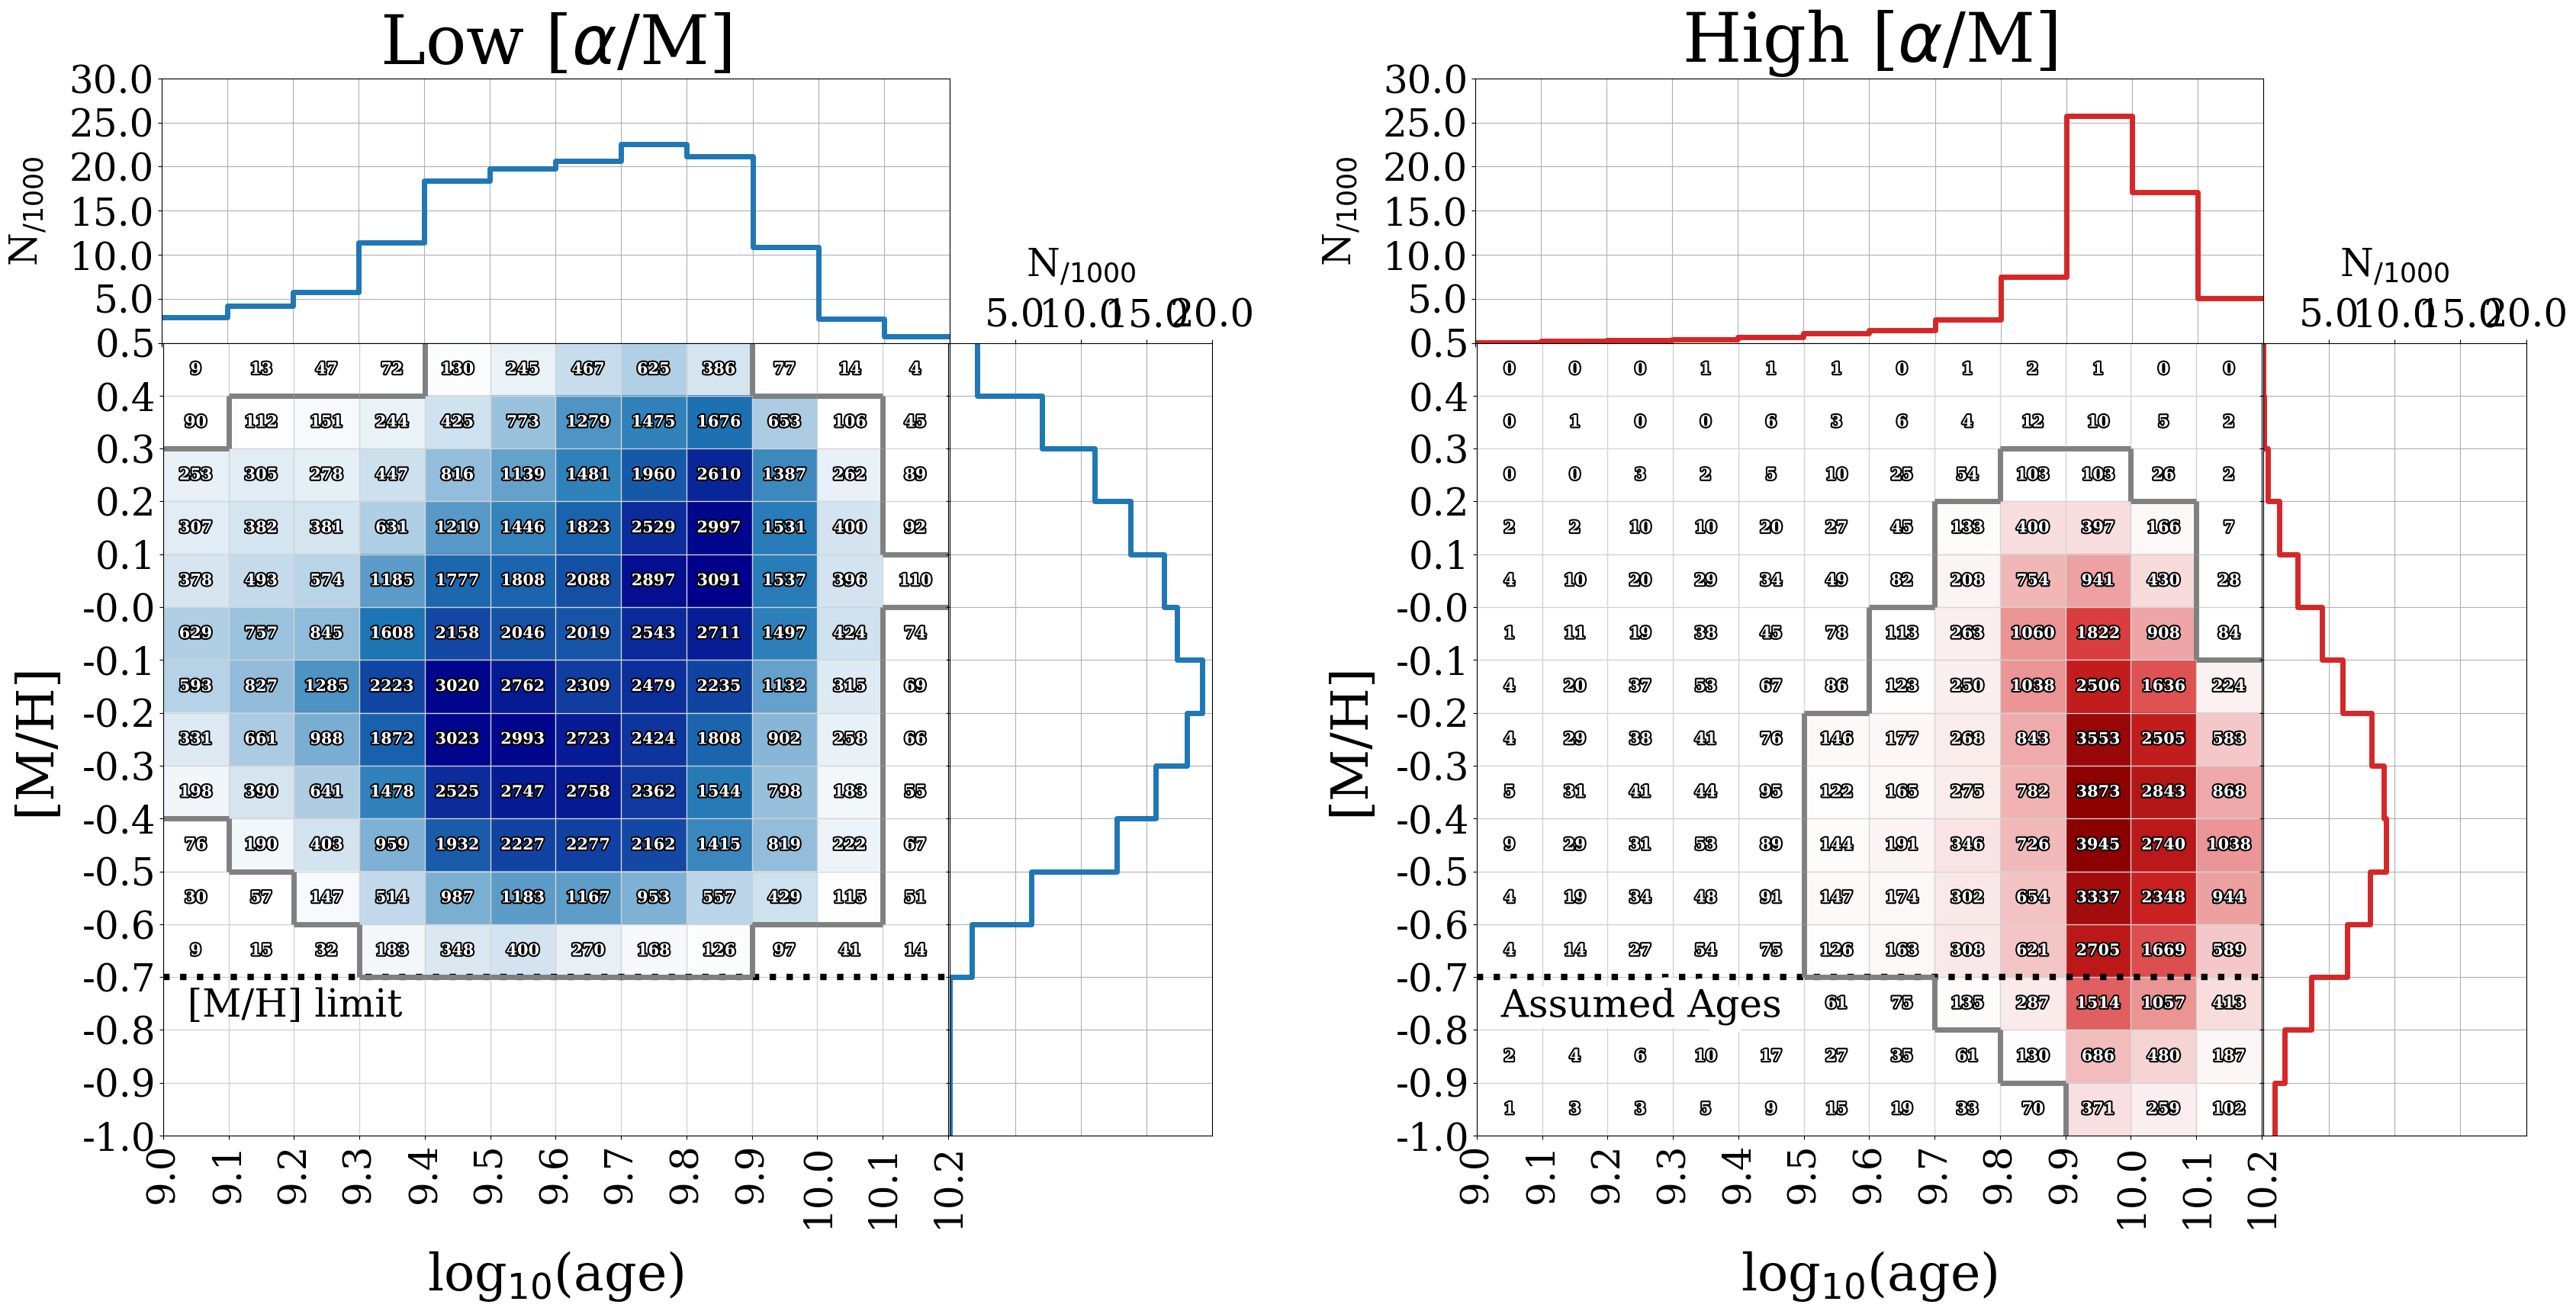

141147.0
62050.0
203197.0


In [7]:
plotting_helpers.bin_count_plot_histo(
    ncount_distmass_low,
    ncount_distmass_high,
    savename=figure_directory + "bincounts.png",
)

print(np.sum(ncount_distmass_low))
print(np.sum(ncount_distmass_high))
print(np.sum(ncount_distmass_low) + np.sum(ncount_distmass_high))